## Prerequisities

### Install packages

We use imblearn library to solve imbalanced dataset by oversampling using SMOTE method.

This library can be installed by running the following cells.

In [1]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We use scikeras library which contains scikit-learn wrapper for Keras models.

This library can be installed by running the following cells.

In [2]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import packages

In [3]:
from imblearn.over_sampling import SMOTENC
from numpy.random import seed
from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.utils import plot_model
from yellowbrick.classifier import ClassPredictionError
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import sys

### Fix randomness

In [4]:
random_state = 42 # We use this constant in different parts of notebook.
set_random_seed(random_state) # This seeds random number in random, numpy and tensorflow. See https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed

### Constant definitions

In [5]:
columns_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
columns_cat = ["island", "sex"]

### Function definitions

In [6]:
def make_preprocessor(columns_num=columns_num, columns_cat=columns_cat):
    preprocessor_num = Pipeline(steps=[
        ("scaler", StandardScaler())  
    ])
    preprocessor_cat = Pipeline(steps=[
        ("onehotencoder", OneHotEncoder())
    ])
    preprocessor = ColumnTransformer(transformers=[
        ("preprocessor_num", preprocessor_num, columns_num),
        ("preprocessor_cat", preprocessor_cat, columns_cat)
    ])
    return preprocessor


def make_pipeline(preprocessor, clf):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("clf", clf)
    ])


def tune_hyperparams(clf, hyperparams, X_train, y_train, columns_num=columns_num, columns_cat=columns_cat, include_preprocessor=False):
    """
    Performs grid search with hyperparams on pipeline with given classifier.
    """
    preprocessor = make_preprocessor(columns_num, columns_cat)
    pipeline = make_pipeline(preprocessor, clf)
    steps = []
    if include_preprocessor:
      steps.append(("preprocessor", preprocessor))
    steps.append(("clf", clf))
    pipeline = Pipeline(steps)
    gscv = GridSearchCV(
        pipeline,
        hyperparams,
        scoring="accuracy",
        verbose=0
    )
    gscv.fit(X_train, y_train)
    print("Best params:", gscv.best_params_)
    print("Best accuracy:", gscv.best_score_)
    return gscv

## Problem Definition

We are performing classification of penguin species.

Our target column is named "species".

Our metrics of success is "accuracy".

## Data Understanding

In [7]:
# Načtení dat
data_raw = pd.read_csv("penguins.csv")

In [8]:
data_raw.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


Our dataset contains:

- 1 column with target variable (`species`)
- 7 columns with possible input features (`island`, `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`, `sex`, `year`)
- 5 columns with numerical values (`bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`, `year`), out of these 4 contains floating numbers (`bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`) and 1 contain integer number (`year`)
- 3 columns with categorical values (`species`, `island`, `sex`)

In [9]:
data_raw["species"].value_counts()

Adelie       160
Gentoo       124
Chinstrap     79
Name: species, dtype: int64

As a result of calling `value_counts()` on our target column shows:

- We are performing a multi-class classification.
- Class counts are imbalanced, therefore we need to solve class imbalance during training. We have decided to use oversampling using SMOTE method to solve class imbalance in our case.

### Indication of missing values

In [10]:
data_raw.isnull().sum().to_frame("number of null values")

,number of null values
species,0
island,0
bill_length_mm,5
bill_depth_mm,5
flipper_length_mm,6
body_mass_g,5
sex,14
year,0


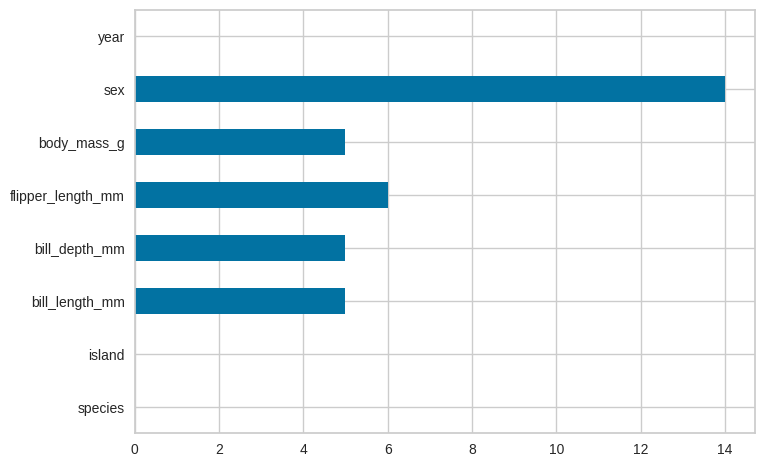

In [11]:
data_raw.isnull().sum().plot(kind="barh");

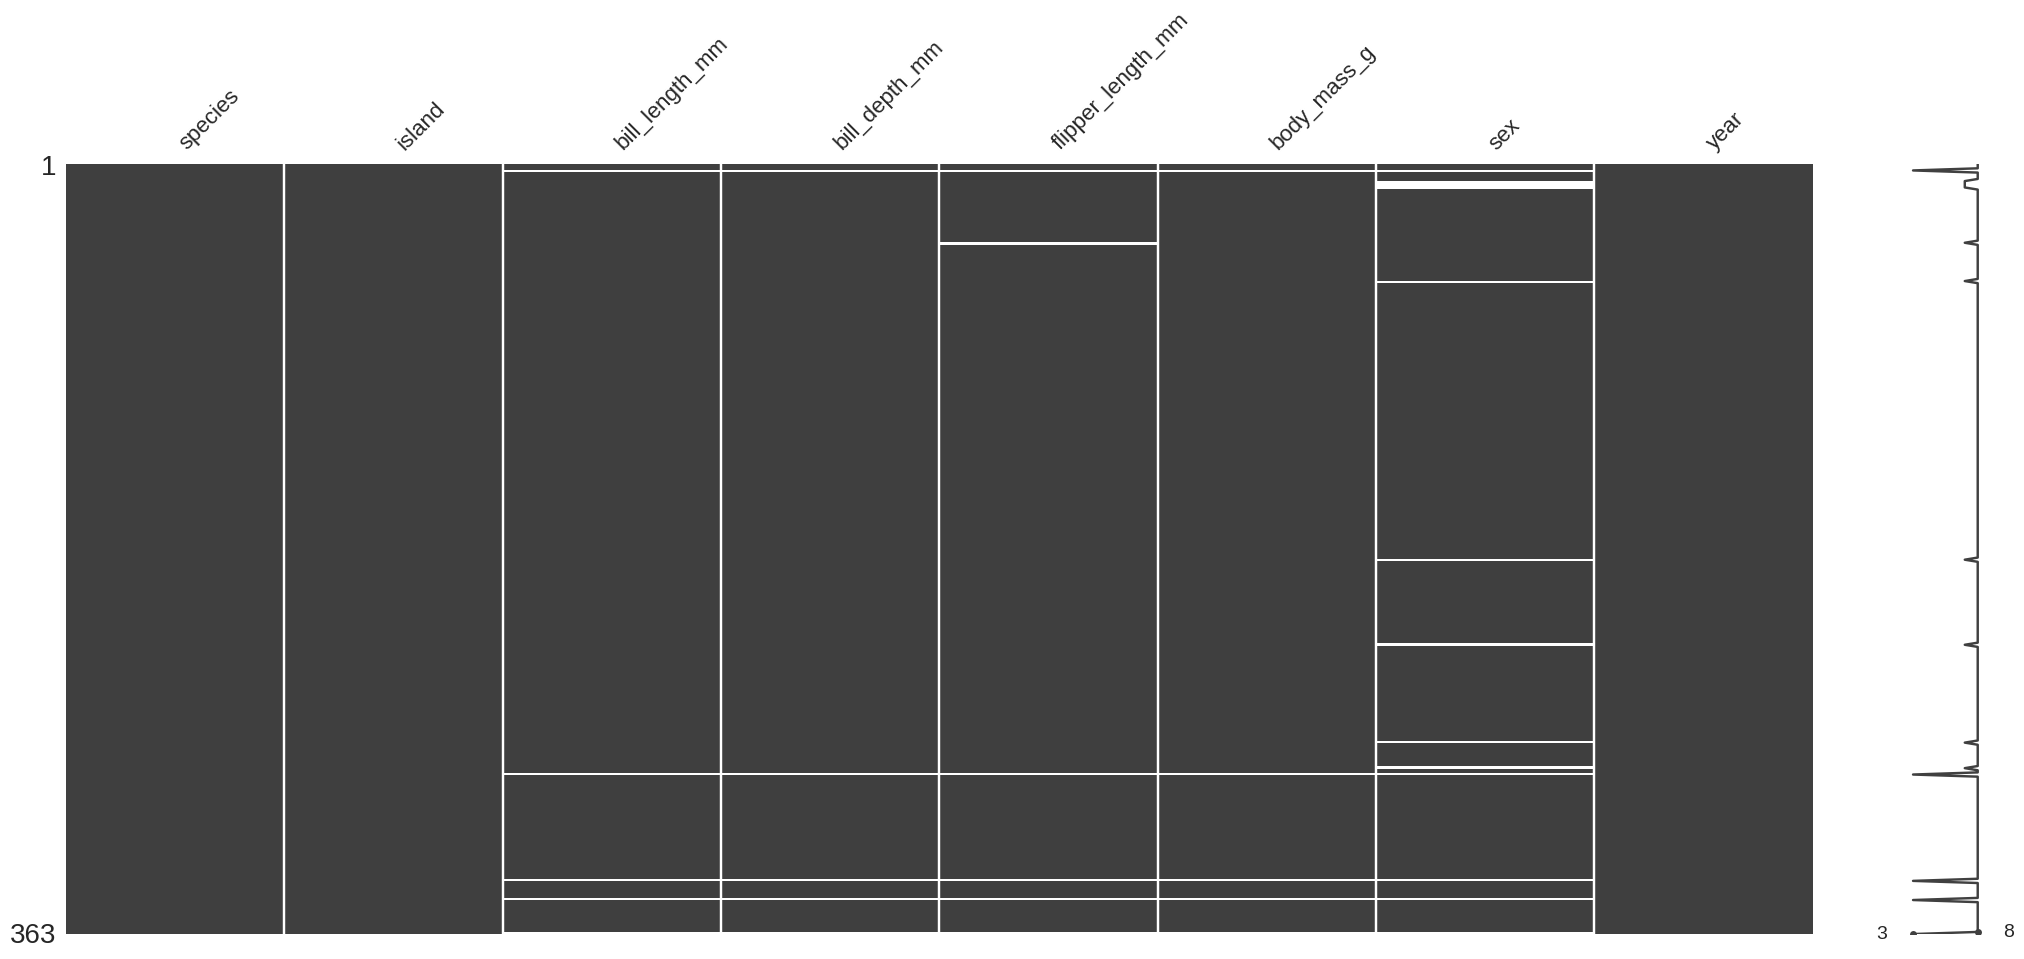

In [12]:
msno.matrix(data_raw)
plt.savefig("fig_missing_values.png")
plt.show()

Our dataset contains a small amount of missing values in columns `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`, `sex`.

### Descriptive statistics

In [13]:
print("Dataset contains {} rows and {} columns.".format(*data_raw.shape))

Dataset contains 363 rows and 8 columns.


In [14]:
data_raw.describe(include = 'all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
count,363,363,358.000000,358.000000,357.000000,358.000000,349,363.000000
unique,3,3,NaN,NaN,NaN,NaN,2,NaN
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,female,NaN
freq,160,170,NaN,NaN,NaN,NaN,175,NaN
mean,NaN,NaN,43.926257,17.205587,200.451261,4173.743017,NaN,2007.991736
std,NaN,NaN,5.441240,1.951749,14.000754,796.395388,NaN,0.829323
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN,2007.000000
25%,NaN,NaN,39.350000,15.700000,190.000000,3550.000000,NaN,2007.000000
50%,NaN,NaN,44.450000,17.500000,197.000000,3950.000000,NaN,2008.000000
75%,NaN,NaN,48.500000,18.700000,213.000000,4743.750000,NaN,2009.000000


### Correlation analysis

<ipython-input-15-2f9a9ba54672>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_raw.corr())


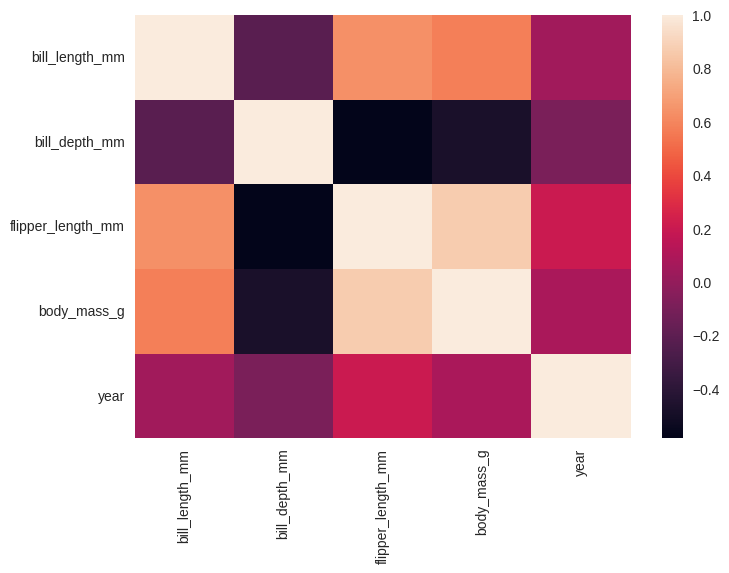

In [15]:
sns.heatmap(data_raw.corr())
plt.savefig("fig_correlation.png")
plt.show()

### Duplicates

In [16]:
print("Number of duplicate rows to delete:", data_raw[data_raw.duplicated(keep="first")].shape[0])

Number of duplicate rows to delete: 13


## Data Preparation

We would like to make a decision about penguin species based on physical characteristics of the penguin and on which island he has been found.
That should both be available at the time of prediction.

We would not like to make a prediction of penguin species based on year
as years change and we might want to make a prediction of penguin species
in future, where year can be some value not found in training data.
That would degrade the quality of predictions. Therefore we remove year column.

In [17]:
def preprocess_remove_year(df):
    """
    Removes year column.
    """
    df.drop(columns="year", inplace=True)


def preprocess_remove_multiple_NaNs_rows(df):
    """
    Removes rows containing 5 or more NaN rows.
    """
    df.drop(index=df[df.isnull().sum(axis = 1) >= 5].index, inplace=True)


def preprocess_remove_duplicates(df):
    """
    Removes duplicate rows, but keep first row of duplicate rows.
    """
    df.drop(index=df[df.duplicated(keep="first")].index, inplace=True)


def preprocess_convert_datatypes(df):
    """
    Performs datatype conversions.
    """
    df["species"] = df["species"].astype("category")
    df["island"] = df["island"].astype("category")
    df["sex"] = df["sex"].astype("category")


def preprocess_fillna_sex_by_unknown_value(df):
    """
    Fills in missing values of sex column
    by filling in a value "unknown".
    """
    df["sex"] = df["sex"].astype("str").fillna("unknown").astype("category")


def preprocess_fillna_sex_by_random_forest_model(df):
    """
    Fills in missing values of sex column
    by training a random forest model on rows, where sex column value is filled
    and using that model to predict value of sex in rows,
    where sex column value is missing.
    """
    df_sex_isna = df[df["sex"].isnull()]
    df_sex_nona = df[df["sex"].notnull()]
    sex_y = df_sex_nona["sex"]
    sex_X = df_sex_nona.drop(columns=["sex"])
    random_forest_model = RandomForestClassifier(random_state=random_state)
    random_forest_hyperparams = {
        'clf__n_estimators': [50], #, 100, 150, 200], 
        'clf__criterion': ['gini', 'entropy'], 
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
    columns_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
    columns_cat = ["island"]
    gscv = tune_hyperparams(random_forest_model, random_forest_hyperparams, sex_X, sex_y, columns_num, columns_cat, include_preprocessor=True)
    sex_predictions = gscv.predict(df_sex_isna)
    df.loc[df["sex"].isnull(), "sex"] = sex_predictions


def preprocess_fillna(df):
    """
    Fills NaN values.
    """
    df["bill_length_mm"].fillna(df["bill_length_mm"].mean(), inplace=True)
    df["bill_depth_mm"].fillna(df["bill_depth_mm"].mean(), inplace=True)
    df["flipper_length_mm"].fillna(df["flipper_length_mm"].mean(), inplace=True)
    df["body_mass_g"].fillna(df["body_mass_g"].mean(), inplace=True)

def preprocess(df, for_training=True):
    """
    Preprocesses dataframe df and returns preprocessed dataframe.
    """
    df_preprocessed = df.copy()
    preprocess_remove_year(df_preprocessed)
    preprocess_remove_multiple_NaNs_rows(df_preprocessed)
    preprocess_remove_duplicates(df_preprocessed)
    preprocess_convert_datatypes(df_preprocessed)

    y = df_preprocessed["species"]
    X = df_preprocessed.drop(columns=["species"])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    preprocess_fillna(X_train)
    preprocess_fillna(X_test)

    preprocess_fillna_sex_by_random_forest_model(X_train)
    preprocess_fillna_sex_by_random_forest_model(X_test)

    #preprocess_fillna_sex_by_unknown_value(X_train)
    #preprocess_fillna_sex_by_unknown_value(X_test)

    # SMOTENC documentation: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html
    if for_training:
        X_train, y_train = SMOTENC([0, 5], random_state=random_state).fit_resample(X_train, y_train)

    preprocessor = make_preprocessor()
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    X_train = pd.DataFrame(X_train_transformed, index=X_train.index, columns=preprocessor.get_feature_names_out())
    X_test = pd.DataFrame(X_test_transformed, index=X_test.index, columns=preprocessor.get_feature_names_out())
 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess(data_raw)

Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Best accuracy: 0.8923130677847659
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
Best accuracy: 0.9120879120879121


In [18]:
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")

## Data Visualization



### Island habitability

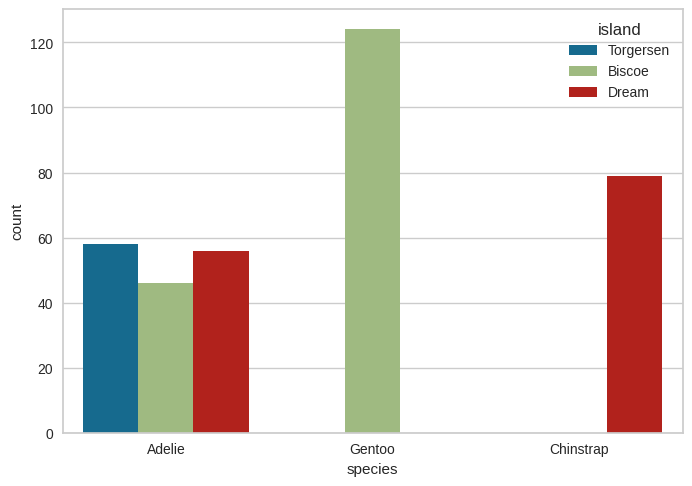

In [19]:
sns.countplot(data_raw, x='species', hue='island')
plt.savefig("fig_island_habitability.png")
plt.show()

- Adelie species are found on all three islands, but Gentoo and Chinstrap are separated.
- Gentoo lives on Biscoe Island
- Chinstrap lives on Dream Island

### Boxplots

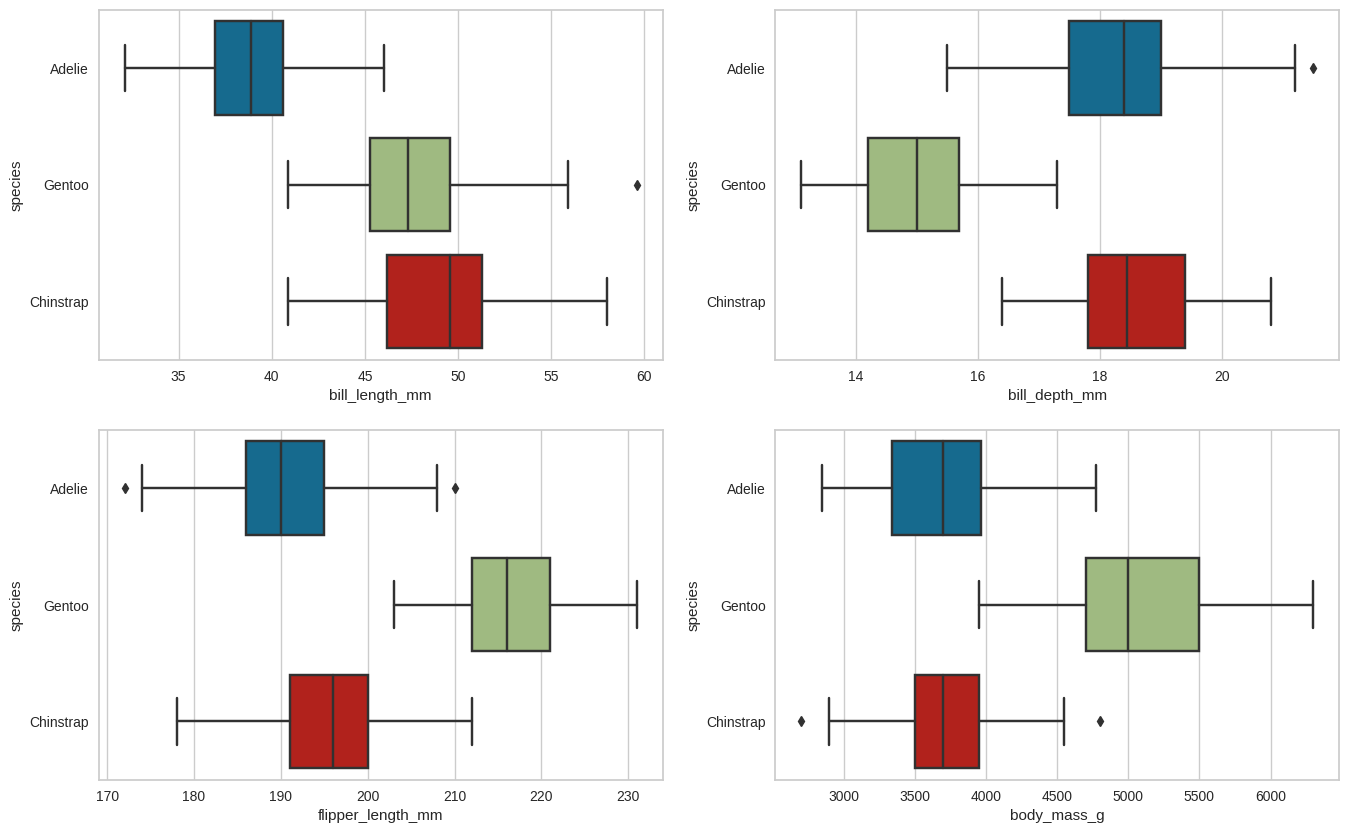

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(x="bill_length_mm", y="species", data=data_raw, ax=ax[0,0])
sns.boxplot(x="bill_depth_mm", y="species", data=data_raw, ax=ax[0, 1])
sns.boxplot(x="flipper_length_mm", y="species", data=data_raw, ax=ax[1,0])
sns.boxplot(x="body_mass_g", y="species", data=data_raw, ax=ax[1,1])
plt.savefig("fig_boxplots.png")
plt.show()

### Pairplot

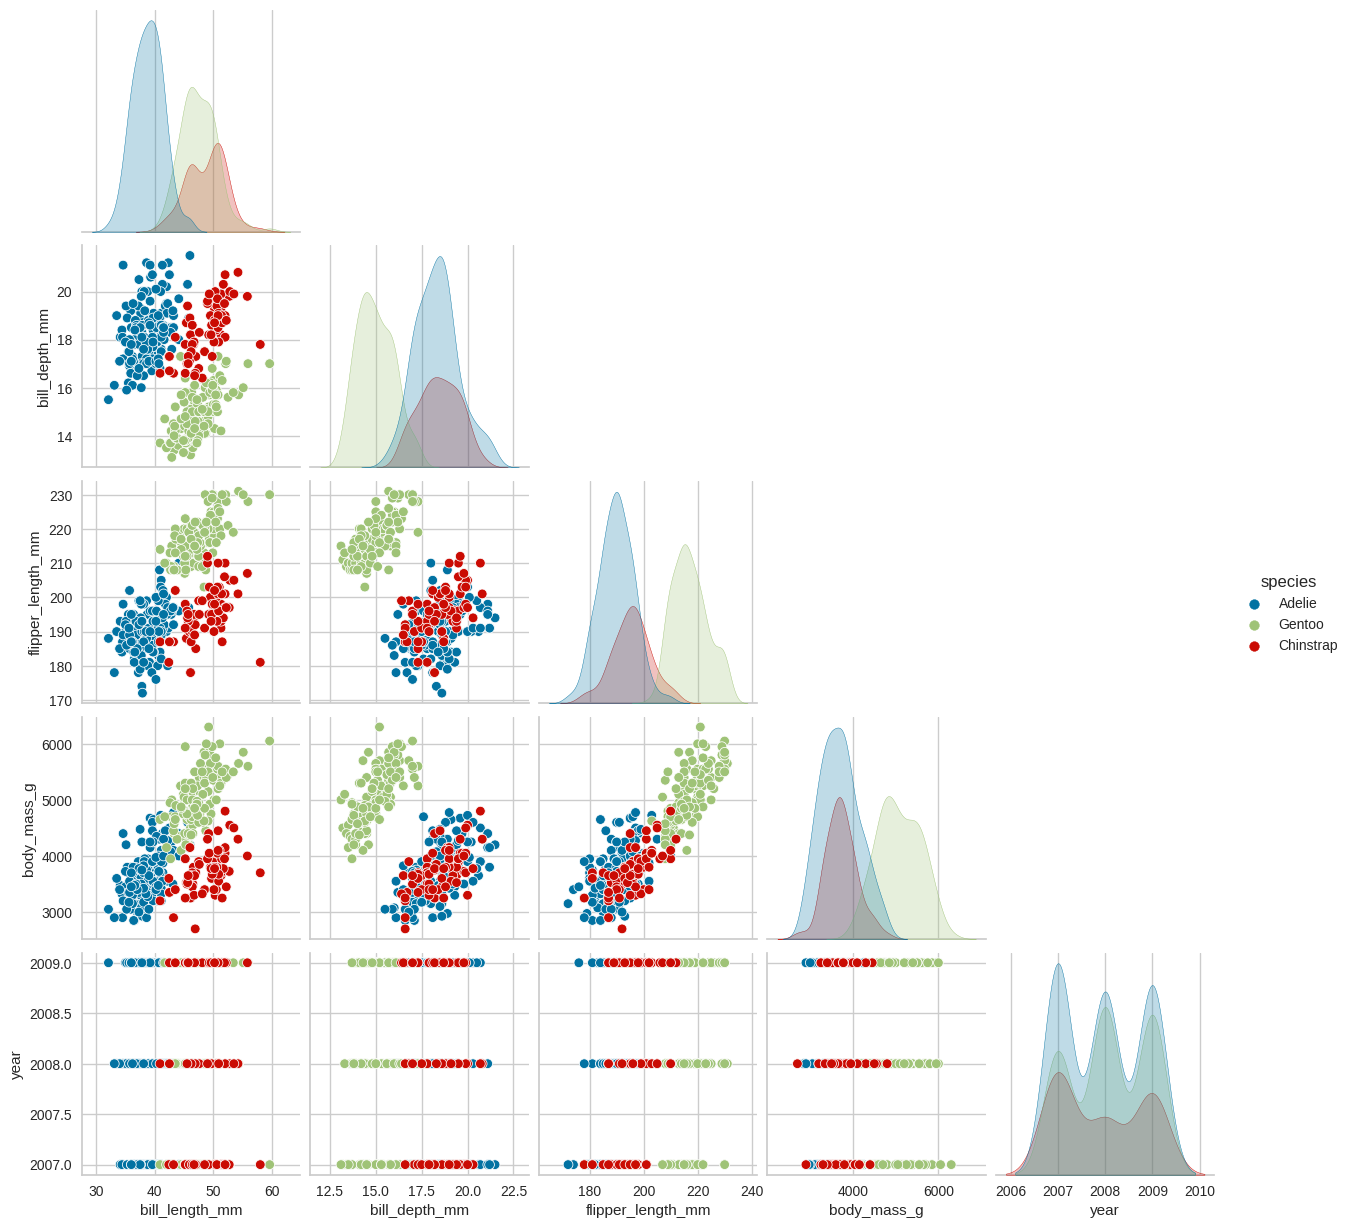

In [21]:
sns.pairplot(data_raw, hue = 'species', corner=True)
plt.savefig("fig_pairplot.png")
plt.show()

### Scatterplots

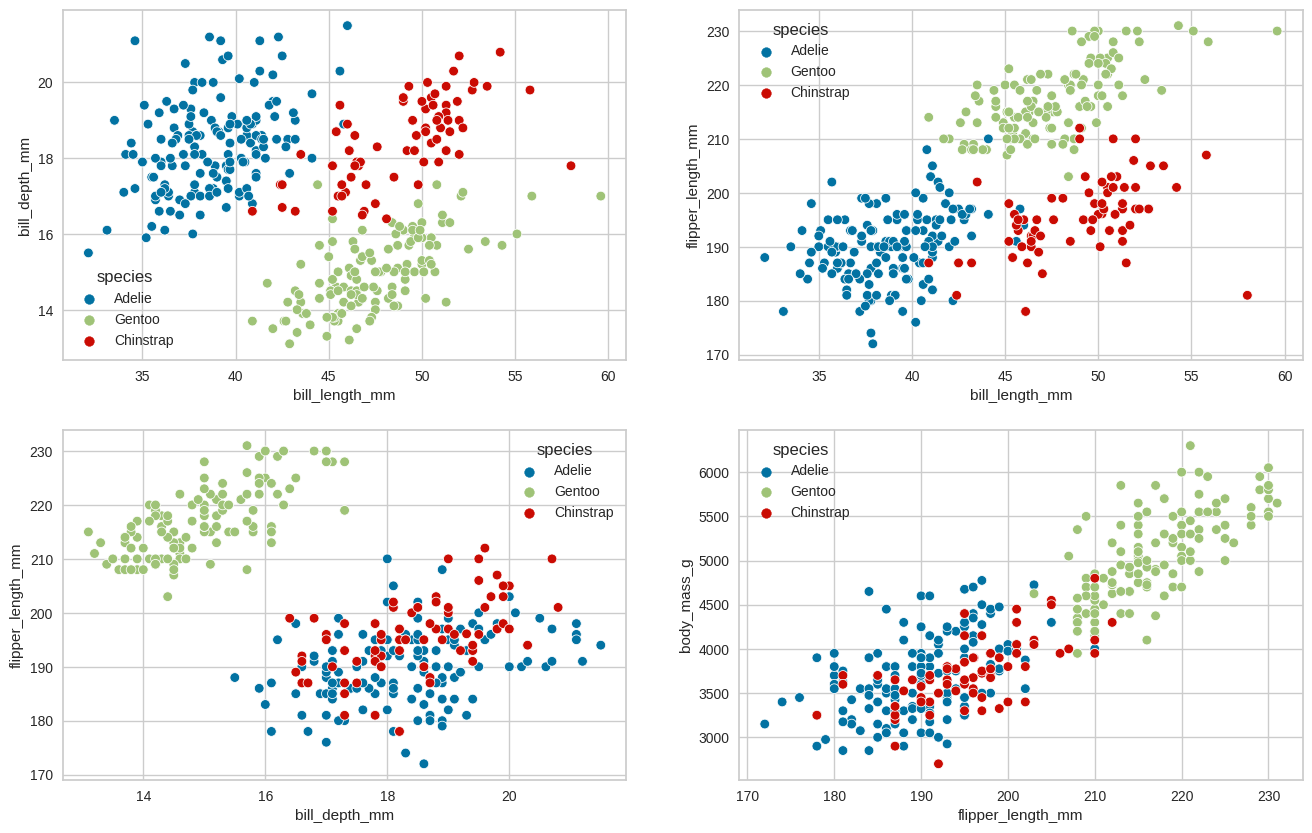

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
sns.scatterplot(x="bill_length_mm", y="bill_depth_mm", hue="species", data=data_raw, ax=ax[0,0])
sns.scatterplot(x="bill_length_mm", y="flipper_length_mm", hue="species", data=data_raw, ax=ax[0,1])
sns.scatterplot(x="bill_depth_mm", y="flipper_length_mm", hue="species", data=data_raw, ax=ax[1,0])
sns.scatterplot(x="flipper_length_mm", y="body_mass_g", hue="species", data=data_raw, ax=ax[1,1])
plt.savefig("fig_scatterplots.png")
plt.show()

### Adelie vs Chinstrap

Let's try to find the differences between Adelie and Chinstrap
We will use the bill_lenth_mm attribute for this, since it is the only attribute that shows significant differences based on the graph of pairwise dependencies.

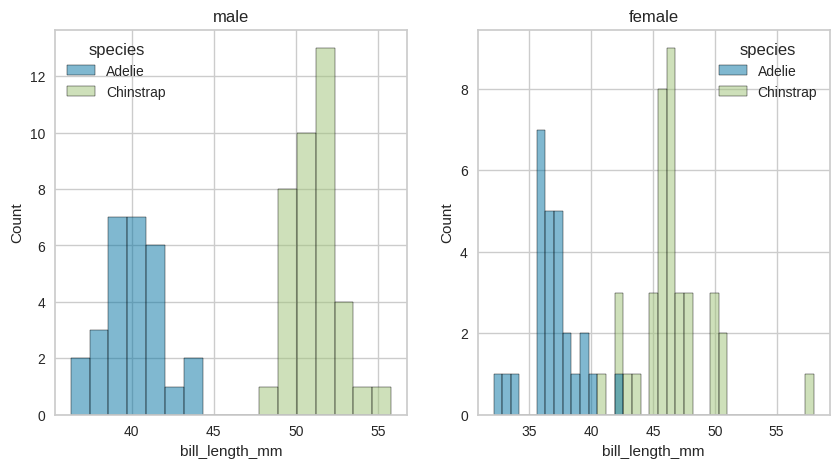

In [23]:
# first, let's prepare filtered data samples by sex and species (Adelie is additionally filtered to Dream Island, because Chinstrap lives only on it)
adelie_male = data_raw[(data_raw['species'] == 'Adelie') & (data_raw['sex'] == 'male') & (data_raw['island'] == 'Dream')]
adelie_female = data_raw[(data_raw['species'] == 'Adelie') & (data_raw['sex'] == 'female') & (data_raw['island'] == 'Dream')]

chinstrap_male = data_raw[(data_raw['species'] == 'Chinstrap') & (data_raw['sex'] == 'male')]
chinstrap_female = data_raw[(data_raw['species'] == 'Chinstrap') & (data_raw['sex'] == 'female')]

# two histograms describing the distribution of the bill_lenth_mm attribute based on gender
adelie_chinstrap_male = pd.concat([adelie_male, chinstrap_male])
adelie_chinstrap_female = pd.concat([adelie_female, chinstrap_female])

plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
sns.histplot(adelie_chinstrap_male, x = 'bill_length_mm', hue = 'species', element = 'bars', bins = 17)
plt.title('male')

plt.subplot(1, 2, 2)
sns.histplot(adelie_chinstrap_female, x = 'bill_length_mm', hue = 'species', bins = 37)
plt.title('female')
plt.savefig("fig_adelie_chinstrap.png")
plt.show()

We can see that Adelie and Chinstrap can be easily separeted if sex = male,
but not so easily if value of sex = female.

Let's look at the female gender in more detail and use a graph of pairwise dependencies.

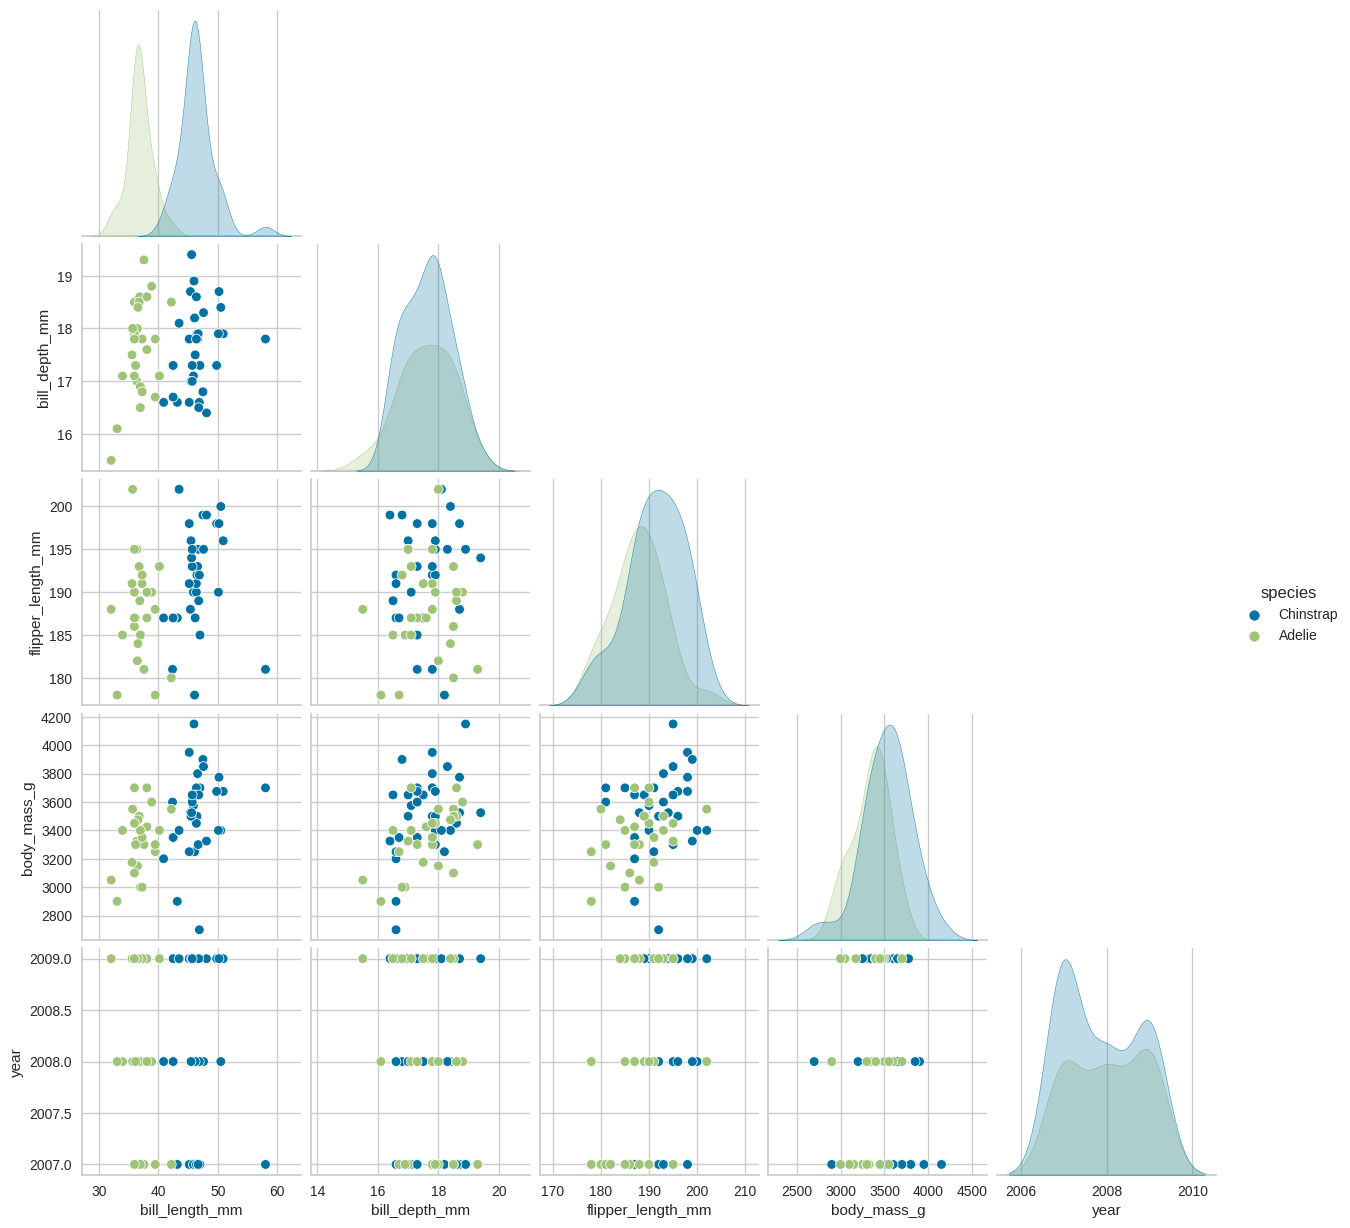

In [24]:
df_adelie_chinstrap_female = pd.concat([chinstrap_female, adelie_female])
sns.pairplot(df_adelie_chinstrap_female, hue= 'species', corner=True)
plt.savefig("fig_adelie_chinstrap2.png")
plt.show()

The best linear separation on the surface we can observe with the attributes x = bill_length_mm y = flipper_length_mm

## Modeling

We decided to try few different models, mainly the ones mentioned in class.
Therefore we have tried:

* Support vector classifier
* Tree model
* Random Forest model
* Neural Network model (in Keras using Scikit-learn compatible wrapper)
* Bagging classifier

In [25]:
accuracies = []

### Model support vector classifier

In [26]:
linearsvc_model = LinearSVC(random_state=random_state)
linearsvc_hyperparams = {
    "clf__C": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

gscv_linearsvc = tune_hyperparams(linearsvc_model, linearsvc_hyperparams, X_train, y_train)
accuracies.append(["linearsvc", gscv_linearsvc.best_score_])

Best params: {'clf__C': 0.5}
Best accuracy: 0.9972602739726029


### Model tree

In [27]:
tree_model = DecisionTreeClassifier(random_state=random_state)
tree_hyperparams = {
    "clf__criterion": ['gini', 'entropy'],
    "clf__max_depth": [2,4,6,8,10,12]
}

gscv_tree = tune_hyperparams(tree_model, tree_hyperparams, X_train, y_train)
accuracies.append(["tree", gscv_tree.best_score_])

Best params: {'clf__criterion': 'gini', 'clf__max_depth': 4}
Best accuracy: 0.9781562384302112


/usr/local/lib/python3.9/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


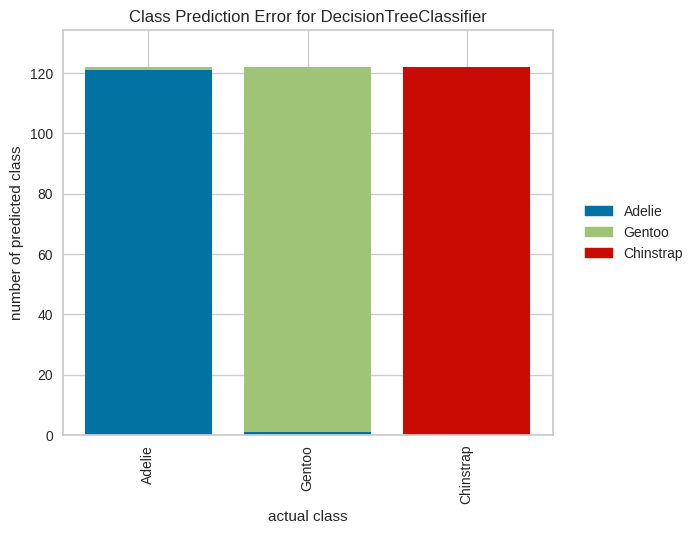

<Axes: title={'center': 'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [28]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    gscv_tree.best_estimator_, classes=y_train.unique()
)

visualizer.score(X_train, y_train)
visualizer.show()

### Model random forest

In [29]:
random_forest_model = RandomForestClassifier(random_state=random_state)
random_forest_hyperparams = {
    'clf__n_estimators': [50], #, 100, 150, 200], 
    'clf__criterion': ['gini', 'entropy'], 
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}
gscv_rfr = tune_hyperparams(random_forest_model, random_forest_hyperparams, X_train, y_train)
accuracies.append(["random forest", gscv_rfr.best_score_])

Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
Best accuracy: 0.9890781192151055


### Model bagging classifier

In [30]:
decision_tree_model = DecisionTreeClassifier(random_state=random_state, criterion="gini", max_depth=4)
bagging_model = BaggingClassifier(random_state=random_state, estimator=decision_tree_model)

bagging_hyperparams = {
    "clf__max_features": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "clf__max_samples": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

gscv_bagging = tune_hyperparams(bagging_model, bagging_hyperparams, X_train, y_train)
accuracies.append(["bagging", gscv_bagging.best_score_])

Best params: {'clf__max_features': 0.6, 'clf__max_samples': 0.6}
Best accuracy: 0.9890781192151055


### Model neural network

In [31]:
num_input_features = X_train.shape[1]
num_predicted_classes = y_train.nunique()

def make_model():
    model = Sequential()
    model.add(Dense(16, input_dim=num_input_features, activation="relu"))
    model.add(Dense(num_predicted_classes, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

neural_network_model = KerasClassifier(model=make_model, epochs=50, verbose=0, random_state=random_state)
neural_network_hyperparams = {}
gscv_neural_network = tune_hyperparams(neural_network_model, neural_network_hyperparams, X_train, y_train)
accuracies.append(["neural_network", gscv_neural_network.best_score_])

Best params: {}
Best accuracy: 1.0


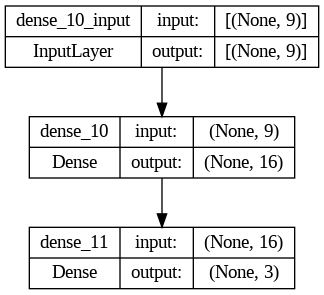

In [32]:
plot_model(gscv_neural_network.best_estimator_["clf"].model_,show_shapes=True, show_layer_names=True, to_file="fig_neural_network_model.png")
plot_model(gscv_neural_network.best_estimator_["clf"].model_,show_shapes=True, show_layer_names=True)

### Model accuracies

In [33]:
df_accuracies = pd.DataFrame(data=accuracies, columns=["model", "accuracy"])
df_accuracies.sort_values(by="accuracy", ascending=False)

,model,accuracy
4,neural_network,1.000000
0,linearsvc,0.997260
2,random forest,0.989078
3,bagging,0.989078
1,tree,0.978156


### Conclusion on selecting the best model

As we can see, the best accuracy has neural network. That is great also because the assignment explicitly mentions we must save model in `h5` format, and we know an easy way how to do it in Keras (which we use in our neural network model) described [here](https://www.tensorflow.org/guide/keras/save_and_serialize) for Keras and [here](https://adriangb.com/scikeras/stable/notebooks/Basic_Usage.html#4.2-Saving-using-Keras-saving-methods) in Chapter 4.2 for scikeras, so we have decided to select neural network as the best model.

Our model is limited by following factors:

- The architecture is limited by number of input features, which places a restriction on the number of neurons in input layer, which must be same as number of input features. We do this by setting `input_dim` parameter of first `Dense` layer, however we probably could achieve the same result by using separate `Input` layer with required number of neurons.
- The architecture is limited by performed task, which is a multi class classification, which places the following restrictions on the network: a) the number of neurons in output layer must be the same as number of predicted classes b) we must use softmax activation function on the last layer, which returns a sequence of predicted class probability scores between `0` and `1` which summs up to `1`, where the class with maximum probability score is the class which should be predicted.

Model could be improved by following ways:

- Using `Dropout` layer would prevent overfitting.

Values of hyperparameters (such as number of layers or number of neurons in layer) are hardcoded in our `make_model()` function and were chosen in such a way that we wanted to start with some small number of layers and neurons and if it would not work well, increase the number of layers or neurons. However, because chosen values worked well, we have not needed to use more complicated networks.

### Save and load trained model

In [34]:
gscv_neural_network.best_estimator_["clf"].model_.save("model.h5")

In [35]:
def load(path):
    keras_model = load_model(path)
    scikeras_model = KerasClassifier(keras_model)
    scikeras_model.initialize(X_train, y_train)
    pipeline = Pipeline(steps=[
        ("clf", scikeras_model)
    ])
    return pipeline

best_model = load("model.h5")

## Evaluation

### Make predictions on test set using best model

In [36]:
y_pred = best_model.predict(X_test)

3/3 [==============================] - 0s 4ms/step


### Show classification report

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        31
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



### Show confusion matrix

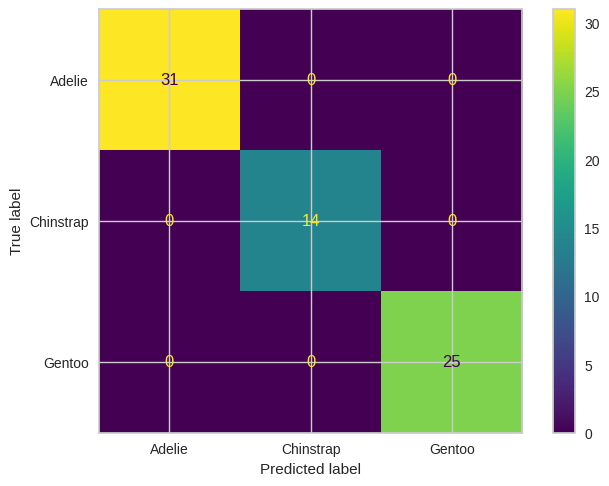

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.savefig("fig_confusion_matrix.png")
plt.show()

As we can see from classification report and confusion matrix, our model achieves 100% accuracy.

## Development Environment Characteristics

### Python version

We use the following Python version:

In [39]:
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


### Packages utilized and their versions

We directly use the following packages:

- `imblearn` - for oversampling using SMOTE method
- `numpy` - for seeding random number for Keras
- `matplotlib` - for visualization
- `pandas` - for working with data in table form
- `scikeras` - contains scikit-learn compatible wrapper which we use
- `seaborn` - for visualization
- `scikit-learn` - for non-neural network models
- `tensorflow` - for neural network models using Keras API
- `yellowbrick` - for visualization of class prediction error

The full list of packages installed in our Google Collab environment and their versions can be found in the following commands output:



In [40]:
!pip freeze

absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==22.2.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.1
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2
defusedxml==0.7.1
distributed==2022.12.1
dlib==19.24.1